In [27]:
# 필요한 라이브러리 import 

import os
import sys
import cv2
import numpy as np
from typing import Tuple, Sequence, Callable, Dict

import torch
from torch import Tensor
from torch.utils.data import Dataset

from torch import nn
# from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from typing import Tuple 
import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import torch.optim as optim


In [28]:
import natsort
from torch import Tensor

In [29]:
sm = []

class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_df: pd.DataFrame,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = label_df
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)
#         print(keypoints)
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]) +1, max(keypoints[:, 1])+1
        
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)
        
        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((15, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets




In [30]:
# Predict Keypoints
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))

In [31]:
def pred_keypoints(frame_path, model_path, device = 'cuda'):
    model = torch.load(model_path)
    model.to(device)
    model.eval()

    pred_list = []
    frame_no = len(os.listdir(frame_path))
#     print(frame_no)
    frames = natsort.natsorted(os.listdir(frame_path))
#     print(frames)
    col = ['0_x', '0_y', '1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '4_x',
       '4_y', '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '8_x', '8_y', '9_x',
       '9_y', '10_x', '10_y', '11_x', '11_y', '12_x', '12_y', '13_x', '13_y',
       '14_x', '14_y']
    test_df = pd.DataFrame(np.zeros((frame_no, 30)), columns = col)
    test_df.insert(0, 'image', frames)

#     print(test_df)
    transforms = A.Compose([
      # A.Resize(500, 500, always_apply=True),
      A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ToTensorV2()
    ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
      keypoint_params=A.KeypointParams(format='xy')
    )
    print(test_df[:])
    testset = KeypointDataset(frame_path, test_df[:], transforms)
    
    test_loader = DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 0, collate_fn = collate_fn)

    with torch.no_grad():
        for images, targets in test_loader:
            # data, target 값 DEVICE에 할당
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  
            
            
            
            predictions = model(images)
            
            for i in range(len(predictions)):
                print(predictions[i]['keypoints'])
                pred_list.append(predictions[i]['keypoints'].cpu().numpy().copy()[0][:, :3].tolist())

    return pred_list


In [32]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [33]:
model_path = './models/RCNN_ep11_2.31104110121727.pt'

In [34]:
frame_path= './temp/'

current_folder = globals()['_dh'][0]
path = os.path.dirname(os.path.join(current_folder,''))
os.chdir(path)

In [35]:
pred_key = pred_keypoints(frame_path, model_path, DEVICE)

                           image  0_x  0_y  1_x  1_y  2_x  2_y  3_x  3_y  4_x   
0        frame_0_timestamp_0.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  \
1     frame_12_timestamp_400.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   frame_102_timestamp_3400.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   frame_108_timestamp_3600.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   frame_114_timestamp_3800.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   frame_120_timestamp_4000.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   frame_126_timestamp_4200.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   frame_132_timestamp_4400.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8   frame_138_timestamp_4600.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9   frame_144_timestamp_4800.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10  frame_150_timestamp_5000.jpg  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11  frame_156_timestamp_5200

tensor([[[286.2707, 592.7570,   1.0000],
         [283.4333, 568.2104,   1.0000],
         [282.4874, 591.8129,   1.0000],
         ...,
         [276.8125, 589.9247,   1.0000],
         [261.6794, 568.2104,   1.0000],
         [265.4626, 586.1483,   1.0000]],

        [[284.2955, 556.6088,   1.0000],
         [308.1477, 521.7363,   1.0000],
         [290.0201, 550.0113,   1.0000],
         ...,
         [277.6169, 556.6088,   1.0000],
         [313.8722, 521.7363,   1.0000],
         [277.6169, 556.6088,   1.0000]],

        [[339.8909, 546.5479,   1.0000],
         [337.0760, 528.9607,   1.0000],
         [356.7807, 529.8863,   1.0000],
         ...,
         [337.0760, 546.5479,   1.0000],
         [365.2256, 522.4812,   1.0000],
         [337.0760, 546.5479,   1.0000]],

        ...,

        [[346.2656, 529.8353,   1.0000],
         [341.4617, 512.8885,   1.0000],
         [362.5986, 527.9523,   1.0000],
         ...,
         [341.4617, 529.8353,   1.0000],
         [399.1077, 48

tensor([[[281.9758, 586.5928,   1.0000],
         [289.5769, 561.8062,   1.0000],
         [281.0256, 585.6395,   1.0000],
         ...,
         [263.9230, 586.5928,   1.0000],
         [263.9230, 586.5928,   1.0000],
         [263.9230, 563.7128,   1.0000]],

        [[287.3143, 583.9845,   1.0000],
         [294.0207, 572.9644,   1.0000],
         [282.5241, 583.9845,   1.0000],
         ...,
         [260.4891, 589.4946,   1.0000],
         [266.2374, 572.9644,   1.0000],
         [260.4891, 573.8828,   1.0000]],

        [[282.2086, 562.9260,   1.0000],
         [282.2086, 546.2381,   1.0000],
         [285.0829, 560.1447,   1.0000],
         ...,
         [258.2553, 562.9260,   1.0000],
         [258.2553, 562.9260,   1.0000],
         [258.2553, 562.9260,   1.0000]],

        ...,

        [[468.3110, 605.3425,   1.0000],
         [445.2917, 578.7419,   1.0000],
         [468.3110, 605.3425,   1.0000],
         ...,
         [445.2917, 605.3425,   1.0000],
         [445.2917, 57

In [36]:
pred_key[0][0][0]

377.2987976074219

In [37]:
x = list()
y = list()

for p in pred_key[0]:
    x.append(p[0])
    y.append(p[1])

print(x)

[377.2987976074219, 379.17486572265625, 372.608642578125, 372.608642578125, 356.6621398925781, 356.6621398925781, 379.17486572265625, 356.6621398925781, 379.17486572265625, 356.6621398925781, 366.04241943359375, 356.6621398925781, 366.98046875, 369.7945556640625, 356.6621398925781]


In [38]:
test_df = pd.DataFrame(pred_key)
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"[377.2987976074219, 537.5184936523438, 1.0]","[379.17486572265625, 528.2899169921875, 1.0]","[372.608642578125, 533.8270874023438, 1.0]","[372.608642578125, 547.6698608398438, 1.0]","[356.6621398925781, 528.2899169921875, 1.0]","[356.6621398925781, 541.2098388671875, 1.0]","[379.17486572265625, 542.1326904296875, 1.0]","[356.6621398925781, 547.6698608398438, 1.0]","[379.17486572265625, 547.6698608398438, 1.0]","[356.6621398925781, 547.6698608398438, 1.0]","[366.04241943359375, 543.9784545898438, 1.0]","[356.6621398925781, 547.6698608398438, 1.0]","[366.98046875, 543.9784545898438, 1.0]","[369.7945556640625, 543.9784545898438, 1.0]","[356.6621398925781, 547.6698608398438, 1.0]"
1,"[317.076171875, 587.03515625, 1.0]","[313.29058837890625, 573.1270751953125, 1.0]","[317.076171875, 593.5255737304688, 1.0]","[315.1833801269531, 597.234375, 1.0]","[283.952392578125, 580.5447387695312, 1.0]","[283.952392578125, 596.3071899414062, 1.0]","[325.59368896484375, 598.16162109375, 1.0]","[317.076171875, 598.16162109375, 1.0]","[331.2720642089844, 598.16162109375, 1.0]","[291.5235595703125, 594.4527587890625, 1.0]","[331.2720642089844, 598.16162109375, 1.0]","[283.952392578125, 598.16162109375, 1.0]","[283.952392578125, 598.16162109375, 1.0]","[283.952392578125, 598.16162109375, 1.0]","[294.36273193359375, 593.5255737304688, 1.0]"
2,"[285.88665771484375, 591.9148559570312, 1.0]","[283.987060546875, 565.932373046875, 1.0]","[283.987060546875, 573.3558959960938, 1.0]","[281.13763427734375, 591.9148559570312, 1.0]","[269.739990234375, 566.8602905273438, 1.0]","[278.2882080078125, 591.9148559570312, 1.0]","[294.43487548828125, 584.4912719726562, 1.0]","[281.13763427734375, 591.9148559570312, 1.0]","[294.43487548828125, 591.9148559570312, 1.0]","[277.33843994140625, 587.275146484375, 1.0]","[294.43487548828125, 590.9869384765625, 1.0]","[277.33843994140625, 590.0589599609375, 1.0]","[277.33843994140625, 589.1310424804688, 1.0]","[264.04119873046875, 565.932373046875, 1.0]","[268.7901916503906, 584.4912719726562, 1.0]"
3,"[288.4406433105469, 592.7603149414062, 1.0]","[282.7208251953125, 567.6342163085938, 1.0]","[285.5807189941406, 575.0789794921875, 1.0]","[282.7208251953125, 592.7603149414062, 1.0]","[272.2344970703125, 568.5648193359375, 1.0]","[274.14111328125, 585.3155517578125, 1.0]","[297.9736633300781, 585.3155517578125, 1.0]","[279.86090087890625, 592.7603149414062, 1.0]","[297.9736633300781, 592.7603149414062, 1.0]","[278.9076232910156, 588.1073608398438, 1.0]","[297.9736633300781, 592.7603149414062, 1.0]","[277.9543151855469, 590.8991088867188, 1.0]","[278.9076232910156, 589.968505859375, 1.0]","[263.65478515625, 567.6342163085938, 1.0]","[270.327880859375, 585.3155517578125, 1.0]"
4,"[286.2707214355469, 592.7570190429688, 1.0]","[283.4332580566406, 568.2103881835938, 1.0]","[282.4874267578125, 591.8128662109375, 1.0]","[281.5415954589844, 591.8128662109375, 1.0]","[268.30010986328125, 569.154541015625, 1.0]","[274.92083740234375, 585.2042236328125, 1.0]","[295.72894287109375, 585.2042236328125, 1.0]","[280.5957946777344, 592.7570190429688, 1.0]","[295.72894287109375, 592.7570190429688, 1.0]","[279.64996337890625, 588.9805908203125, 1.0]","[295.72894287109375, 592.7570190429688, 1.0]","[276.8125, 590.8688354492188, 1.0]","[276.8125, 589.9246826171875, 1.0]","[261.6793518066406, 568.2103881835938, 1.0]","[265.462646484375, 586.1483154296875, 1.0]"
5,"[287.5546569824219, 592.7528076171875, 1.0]","[281.8861999511719, 568.6406860351562, 1.0]","[284.720458984375, 588.1158447265625, 1.0]","[281.8861999511719, 592.7528076171875, 1.0]","[268.6597900390625, 568.6406860351562, 1.0]","[273.38348388671875, 585.3336791992188, 1.0]","[296.057373046875, 585.3336791992188, 1.0]","[279.0519714355469, 592.7528076171875, 1.0]","[296.057373046875, 592.7528076171875, 1.0]","[277.1624755859375, 588.1158447265625, 1.0]","[296.057373046875, 592.7528076171875, 1.0]","[277.1624755859375, 590.8980102539062, 1.0]","[277.16247

In [39]:
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
def pil_draw_point(image, point):
    x, y = point

    draw = ImageDraw.Draw(image)
    radius = 4
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=(0, 255, 255))

    return image

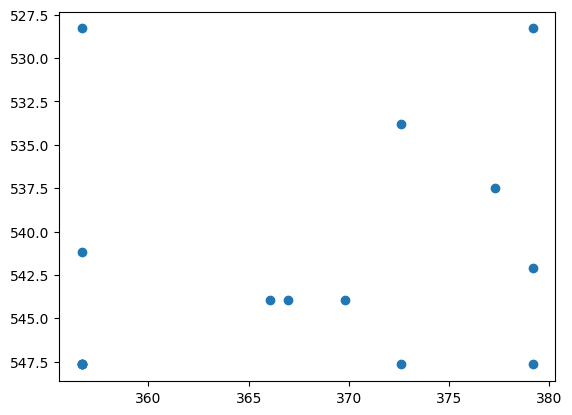

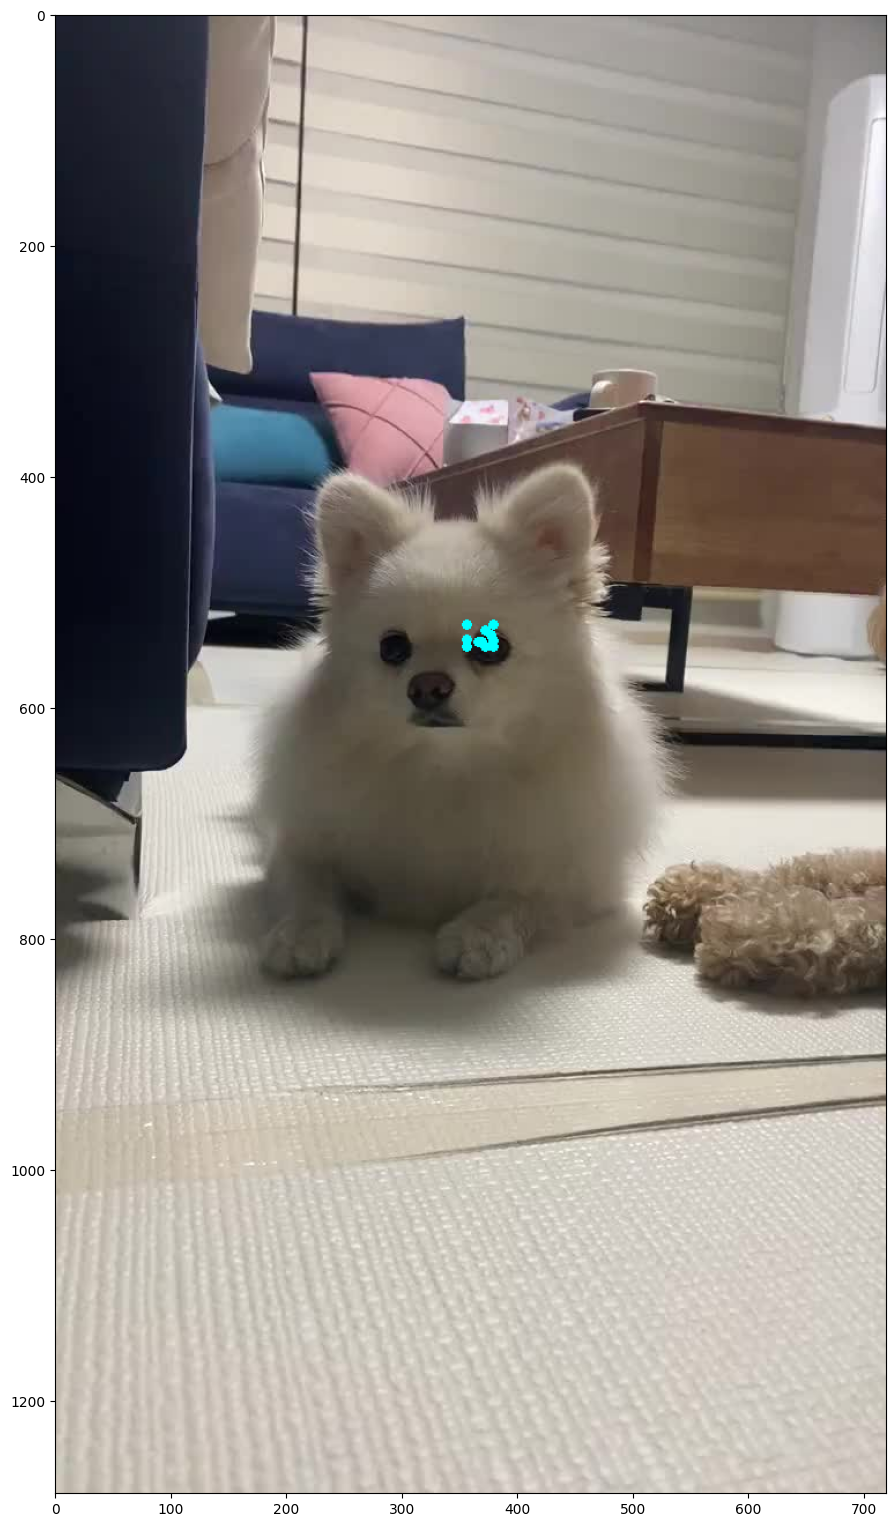

In [40]:
fig, (ax1) = plt.subplots()
plt.figure(figsize=(1080 / fig.dpi,1920/ fig.dpi))

ax1.scatter(x,y)
ax1.invert_yaxis()

image = Image.open(frame_path + 'frame_0_timestamp_0.jpg')
draw = ImageDraw.Draw(image)

for x_points, y_points in zip(x,y):
    #draw.point((x_points, y_points) , fill=(0, 255, 255))

    image = (pil_draw_point(image, (x_points, y_points)))
    
plt.imshow(image)
plt.show()